# Multi-Agent Project
---
A multi-agent DDPG framework to solve the Collaboration and Competition Project as part of [Udacity's Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import math 
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

from unityagents import UnityEnvironment

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. Depending on the operating system, the ``TENNIS_PATH`` to the Unity environment migth need to change.

In [2]:
TENNIS_PATH = "Tennis.app"

env = UnityEnvironment(file_name=TENNIS_PATH,worker_id=1, seed=1) # Otherwise Unity crashes...
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
num_agents = states.shape[0]

print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


### 3. Simplify the Interface of the Environment

The environment returns a ``BrainInfo`` object with attributes for the new state, the reward, and other information. The following helper function unpacks the values for ``next_state``, ``reward``, and ``done``.

In [3]:
def open_brain_surgery(brain):
    """Helper function to unpack BrainInfo Object.
    
    Params
    ======
        brain (BrainInfo) : Single BrainInfo Object
    """
    next_state = brain.vector_observations
    reward = brain.rewards
    done = brain.local_done
    return (next_state, reward, done)

The environment explicitly rewards agents with a rewarrd of ``+0.1`` for hitting the ball ove the net. To test whether the agents can also be successfully trained if they are only rewarded or punished for winning or losing, the rewards can be transformed using the  ``transform_rewards`` function:

In [4]:
def transform_rewards(reward):
    """Helper function to transform the rewards.
    
    Params
    ======
        rewards (list) : List of rewards
    """
    if reward[0] < 0:
        r = [-1.0,1.0]
    elif reward[1] < 0:
        r = [1.0,-1.0]
    else:
        r = [0.0,0.0]
    return r

### 4. Define the Training Function

The cell below trains the agent from scratch and saves the checkpoints when the environment is solved (average score > 0.5). 
If one agent object is passed to the function, the network will be trained jointly for both agents. If a second agent object is passed to ``agent2``, the agents will be trained separately.
If ``highscore = True``, the agent continues to train until the maximum number of episodes is reached and saves the model whenever a new highscore is achieved. If ``competitive = True``, the agents are not explicitly rewarded for hitting the ball over the net, but only for winning the game.

In [5]:
def train(agent1, agent2=None, n_episodes=10000, highscore=False, competitive=False):
    """Multi Agent Deep Deterministic Policy Gradient.
    
    Params
    ======
        agent1 (agent): first instance of agent class 
        agent2 (agent): second instance of agent class (optional)
        n_episodes (int): maximum number of training episodes
        highscore (bool): If True training continues after the environment has been solved
        competitive (bool): train agents competitively (optional)
    """
    max_score = 0.4                    # keep track of highest winning score
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        state, _, _ = open_brain_surgery(env.reset(train_mode=True)[brain_name])
        score = 0
        scores_agents = np.zeros(num_agents) 
        # train agents separately if agent2 is provided
        if agent2:
            agent1.reset()
            agent2.reset()
        else:
            agent1.reset()
        while True:
            # get action from agents
            if agent2:
                action = np.random.randn(num_agents, action_size)
                action[0] = agent1.act(state[0])
                action[1] = agent2.act(state[1])
            else:
                action = agent1.act(state)
            # get next step from the environment    
            next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
            scores_agents += reward
            # transform rewards if trained in competitive mode
            if competitive:
                reward = transform_rewards(reward)
            # update agents
            if agent2:
                agent1.step([state[0]], [action[0]], [reward[0]], [next_state[0]], [done[0]])
                agent2.step([state[1]], [action[1]], [reward[1]], [next_state[1]], [done[1]])
            else:
                agent1.step(state, action, reward, next_state, done)
            state = next_state
            # scores_agents += reward
            if np.any(done):
                break 
        score = np.max(scores_agents)     # take score max of agents
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avg_score = np.mean(scores_window)
        top_score = np.mean(scores_window)
        if i_episode % 100 == 0:            # report training progress
            print('\rEpisode {}\t Best Score: {:.2f}, Average Score: {:.2f}'.format(i_episode, top_score, avg_score))
        if math.floor(avg_score*10)/10 > max_score:
            if max_score == 0.4:          # environment solved (the average score is rounded down)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            else:                         # new high score achieved
                print('\nNew high score after {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            max_score = math.floor(avg_score*10)/10
            # save checkponts:
            if competitive:
                stub = '_comp'
            else:
                stub = ''
            if agent2:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor'+stub+'_1.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic'+stub+'_1.pth')
                torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor'+stub+'_2.pth')
                torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic'+stub+'_2.pth')
            else:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor'+stub+'.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic'+stub+'.pth')
            if not highscore:
                break
    return scores


def plot_scores(scores):
    """Plot Scores.
    
    Params
    ======
        scores (list): list of score for each episode
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Train the Agents

The ``Agent`` class contains the DDPG agent.

The number of hidden layers (at least one) and their neurons for the actor and the critic networks can be passed in lists to the hidden_sizes_actor and hidden_sizes_critic parameters. The default is ``hidden_sizes_actor = [64,64]`` for the actor, i.e., two layers with 64 neurons each, and ``hidden_sizes_critic = [128, 64, 32]`` for the critic.

Hyperparameters for the learning process can be changed at the beginning of the ``agent.py`` file and are set to:

- ``BUFFER_SIZE = int(1e5)``

- ``BATCH_SIZE = 128``

- ``GAMMA = 0.99``

- ``TAU = 1e-3``

- ``LR_ACTOR = 1e-4``

- ``LR_CRITIC = 1e-3``

- ``WEIGHT_DECAY_AC = 0``

- ``WEIGHT_DECAY_CR = 0``

In the following, the agents are trained in two different settings:
1. Using one Actor and one Critic to jointly train both players.
2. Using two Actors and Critics to each train one player.

In addition, we test whether the agents can still learn to pass the ball under zero-sum tennis rewards -- instead of being rewarded for passes over the net, players receive ``+1.0`` for winning the game and ``-1.0`` for losing. Again, the agents are trained in two different settings:
3. Using one Actor and one Critic with competing rewards
4. Using two Actors and Critics with competing rewards

#### 5.1 Train jointly

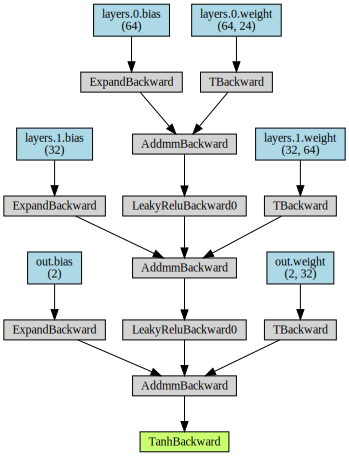

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0, 
              hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])
agent.show_actor_local()

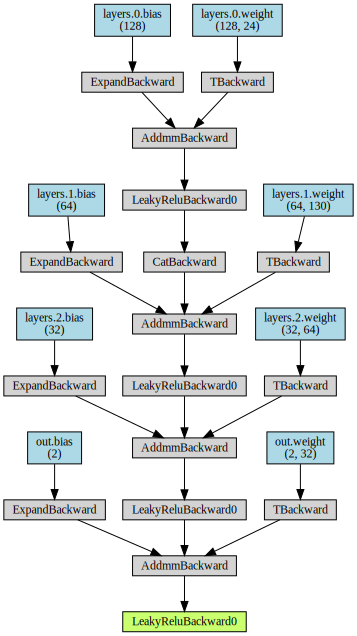

In [7]:
agent.show_critic_local()

Episode 100	 Best Score: 0.01, Average Score: 0.01
Episode 200	 Best Score: 0.00, Average Score: 0.00
Episode 300	 Best Score: 0.00, Average Score: 0.00
Episode 400	 Best Score: 0.00, Average Score: 0.00
Episode 500	 Best Score: 0.00, Average Score: 0.00
Episode 600	 Best Score: 0.02, Average Score: 0.02
Episode 700	 Best Score: 0.03, Average Score: 0.03
Episode 800	 Best Score: 0.03, Average Score: 0.03
Episode 900	 Best Score: 0.04, Average Score: 0.04
Episode 1000	 Best Score: 0.14, Average Score: 0.14
Episode 1100	 Best Score: 0.12, Average Score: 0.12
Episode 1200	 Best Score: 0.13, Average Score: 0.13
Episode 1300	 Best Score: 0.22, Average Score: 0.22

Environment solved in 1296 episodes!	Average Score: 0.51



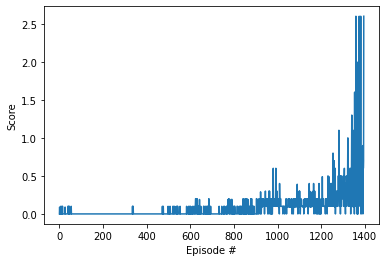

In [8]:
scores = train(agent)
plot_scores(scores)

#### 5.2 Train separately

In [9]:
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=0, 
               hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=1, 
               hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])

Episode 100	 Best Score: 0.00, Average Score: 0.00
Episode 200	 Best Score: 0.00, Average Score: 0.00
Episode 300	 Best Score: 0.01, Average Score: 0.01
Episode 400	 Best Score: 0.03, Average Score: 0.03
Episode 500	 Best Score: 0.03, Average Score: 0.03
Episode 600	 Best Score: 0.03, Average Score: 0.03
Episode 700	 Best Score: 0.04, Average Score: 0.04
Episode 800	 Best Score: 0.05, Average Score: 0.05
Episode 900	 Best Score: 0.05, Average Score: 0.05
Episode 1000	 Best Score: 0.05, Average Score: 0.05
Episode 1100	 Best Score: 0.05, Average Score: 0.05
Episode 1200	 Best Score: 0.08, Average Score: 0.08
Episode 1300	 Best Score: 0.11, Average Score: 0.11
Episode 1400	 Best Score: 0.11, Average Score: 0.11
Episode 1500	 Best Score: 0.10, Average Score: 0.10
Episode 1600	 Best Score: 0.10, Average Score: 0.10
Episode 1700	 Best Score: 0.13, Average Score: 0.13
Episode 1800	 Best Score: 0.13, Average Score: 0.13
Episode 1900	 Best Score: 0.12, Average Score: 0.12
Episode 2000	 Best Sc

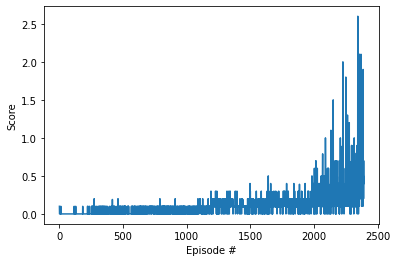

In [10]:
scores = train(agent1, agent2)
plot_scores(scores)

#### 5.3 Train jointly in competitive mode

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0, 
              hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])

In [ ]:
scores = train(agent, competitive = True)
plot_scores(scores)

#### 5.4 Train separately in competitive mode

In [13]:
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=0, 
               hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=1, 
               hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])

In [ ]:
scores = train(agent1, agent2, competitive = True)
plot_scores(scores)

Episode 100	 Best Score: 0.00, Average Score: 0.00
Episode 200	 Best Score: 0.00, Average Score: 0.00
Episode 300	 Best Score: 0.00, Average Score: 0.00
Episode 400	 Best Score: 0.00, Average Score: 0.00
Episode 500	 Best Score: 0.01, Average Score: 0.01
Episode 600	 Best Score: 0.01, Average Score: 0.01
Episode 700	 Best Score: 0.01, Average Score: 0.01
Episode 800	 Best Score: 0.03, Average Score: 0.03
Episode 900	 Best Score: 0.03, Average Score: 0.03
Episode 1000	 Best Score: 0.02, Average Score: 0.02
Episode 1100	 Best Score: 0.03, Average Score: 0.03
Episode 1200	 Best Score: 0.05, Average Score: 0.05
Episode 1300	 Best Score: 0.03, Average Score: 0.03
Episode 1400	 Best Score: 0.00, Average Score: 0.00
Episode 1500	 Best Score: 0.01, Average Score: 0.01
Episode 1600	 Best Score: 0.05, Average Score: 0.05
Episode 1700	 Best Score: 0.05, Average Score: 0.05
Episode 1800	 Best Score: 0.05, Average Score: 0.05
Episode 1900	 Best Score: 0.04, Average Score: 0.04
Episode 2000	 Best Sc

### 6. Watch the Trained Agents

The next cell loads the checkpoints for trained agents to watch them in action.

In [ ]:
# load the weights from file
def watch_agent(agent1, agent2=None, file_name_actor = None, file_name_critic = None, competitive=False):
    """Watch Trained Agents.
    
    Params
    ======
        agent1 (agent): first instance of agent class 
        agent2 (agent): second instance of agent class (optional)
        file_name_actor (path): path to a trained actor compatible with the agent (optional)
        file_name_critic (path): path to a trained critic compatible with the agent (optional)
        competitive (bool): load competitively trained agents (optional)
    """
    # Get file names
    if competitive:
        stub = '_comp'
    else:
        stub = ''
    if file_name_actor is None:
        file_name_actor = 'checkpoint_actor'+stub
    if file_name_critic is None:
        file_name_critic = 'checkpoint_critic'+stub
        
    # Load weights
    if agent2:
        agent1.actor_local.load_state_dict(torch.load(file_name_actor+'_1.pth'))
        agent1.critic_local.load_state_dict(torch.load(file_name_critic+'_1.pth'))
        agent2.actor_local.load_state_dict(torch.load(file_name_actor+'_2.pth'))
        agent2.critic_local.load_state_dict(torch.load(file_name_critic+'_2.pth'))
    else:
        agent1.actor_local.load_state_dict(torch.load(file_name_actor+'.pth'))
        agent1.critic_local.load_state_dict(torch.load(file_name_critic+'.pth'))

    # Initiate and run            
    state, _, _ = open_brain_surgery(env.reset(train_mode=False)[brain_name])
    scores_agents = np.zeros(num_agents) 
    
    # run agents separately if agent2 is provded
    if agent2:
        agent1.reset()
        agent2.reset()
    else:
        agent1.reset()
        
    while True:
        # get action from agents
        if agent2:
            action = np.random.randn(num_agents, action_size)
            action[0] = agent1.act(state[0])
            action[1] = agent2.act(state[1])
        else:
            action = agent1.act(state)
        # get next step from the environment    
        next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
        state = next_state
        scores_agents += reward
        if np.any(done):
            break 
    score = np.mean(scores_agents)
    print('Game score: {}'.format(score))

In [ ]:
watch_agent(agent)

In [ ]:
watch_agent(agent1, agent2)

In [ ]:
env.close()

### 7. Possible Extensions

Performance and training speed could potentially be increased further:

1. The hyperparameters used are likely not optimal. In particular, it is likely that the optimal learning, update, and decay rates will differ in the setting where agents are trained separately. Additional tuning or grid search could be used to make the training more efficient.
2. The ReplayBuffer class could be appended to support prioritized experience replay.
3. Switching to more advanced algorithms, such as D4PG, A3C, TPRO, or PPO might yield better performance.